# Libraries / ライブラリー

In [1]:
# Install packages
# パッケージのインストール
!pip install pydeck-carto geopandas carto-auth[carto-dw] db_dtypes -q xgboost category-encoders numpy shap matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 75.3 MB/s eta 0:00:00


In [2]:
# Carto / GoogleBigQuery
import pydeck as pdk
import pydeck_carto as pdkc
from carto_auth import CartoAuth
from google.cloud import bigquery

# Plotting / プロット
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Analysis / 分析
import numpy as np
import pandas as pd
import geopandas as gpd

# Machine Learning / 機械学習
import xgboost as xgb
import category_encoders as ce
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    cross_val_score,
    train_test_split,
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Authentication / 認証

In [3]:
# Authenticate Carto
# Cartoを認証する
carto_auth = CartoAuth.from_oauth()
carto_dw_client = carto_auth.get_carto_dw_client()

Go to the following URL:
https://auth.carto.com/authorize?client_id=0dxb8HR3ATXCxJiPOJVHsLoHoAtbRX6u&response_type=code&scope=None&audience=carto-cloud-native-api&redirect_uri=https%3A%2F%2Fapp.carto.com%2Fauth%2Ftoken&code_challenge_method=S256&code_challenge=MHMq6fppLZo0zSEDwbEkPdZD0chwx_AIi5Q6JM5KqZQ
Enter the Access code: 
YjYHRjg70d1NTGHXYMt0SfYNVYFMZo7Ge4LWuFEWj4sqz


# Accessing Data / データへのアクセス

## CARTO Data Warehouse / CARTOデータウェアハウス

In [4]:
# List datasets in Carto Data Warehouse
# Cartoデータウェアハウスのデータセットの表示
datasets = list(carto_dw_client.list_datasets())

if datasets:
    print("Datasets in CARTO Data Warehouse:")
    for dataset in datasets:
        print("\t{}".format(dataset.dataset_id))
else:
    print("CARTO Data Warehouse project does not contain any datasets.")

Datasets in CARTO Data Warehouse:
	private_christopher_kyed_3_a1907fcc
	shared
	shared_us
	workflows_temp_christopher_kyed_3_a1907fcc
	workflows_temp_christopher_kyed_3_a1907fcc_us


In [5]:
# List tables in chosen dataset
# 選択したデータセットのテーブルをリストアップする
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)  # Make an API request.

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))


Tables contained in 'shared_us':
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_joined
carto-dw-ac-zn8l36fh.shared_us.london_listings_2023_predicted


In [6]:
# Provide your own Carto Data Observatory ID here.
# ここにあなた自身のCarto Data Observatory IDを入力してください。
cdw_dataset = "carto-dw-ac-zn8l36fh"

In [7]:
# Query the London Listings table and visualize as GeoDataFrame
# London Listingsテーブルを照会し、GeoDataFrameとして可視化する。
table = carto_dw_client.get_table(f"{cdw_dataset}.shared_us.london_listings_2023")
gdf = carto_dw_client.list_rows(table).to_geodataframe(
    geography_column="geom", create_bqstorage_client=False
)
display(gdf.head())

,geom,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,POINT (0.04284 51.43846),606063,Home in London · 1 bedroom · 1 bed · 1 bath,3001445,Doreen,None,Greenwich,51.43846000000000000000000000000000000000,0.04284000000000000000000000000000000000,Private room,55,1,0,NaT,None,1,0,0,None
1,POINT (-0.27005 51.56624),1959198,Home in Kensal Rise · 1 bedroom · 1 bed · 1 bath,9608265,Jennifer,None,Brent,51.56624000000000000000000000000000000000,-0.27005000000000000000000000000000000000,Private room,50,7,0,NaT,None,1,342,0,None
2,POINT (-0.03618 51.49719),5659712,Rental unit in London · 1 bedroom · 1 bed · 1 ...,29336367,Samera,None,Southwark,51.49719000000000000000000000000000000000,-0.03618000000000000000000000000000000000,Private room,160,1,0,NaT,None,1,0,0,None
3,POINT (-0.08285 51.54068),6635074,Home in London · 3 bedrooms · 4 beds · 1.5 baths,34728927,Naomi,None,Hackney,51.54068000000000000000000000000000000000,-0.08285000000000000000000000000000000000,Entire home/apt,150,14,0,NaT,None,1,0,0,None
4,POINT (-0.19413 51.51109),6635515,Rental unit in London · 2 bedrooms · 2 beds · ...,8311047,Jean-Claude,None,Kensington and Chelsea,51.51109000000000000000000000000000000000,-0.19413000000000000000000000000000000000,Entire home/apt,170,1,0,NaT,None,1,0,0,None


## Data Observatory / データ・オブザーバートリー

In [8]:
# Provide your own Carto Data Observatory ID here.
# ここにあなた自身のCarto Data Observatory IDを入力してください。
dataobs_dataset = "carto-data.ac_zn8l36fh"

In [9]:
# Get a list of all subscribed tables
# 購読されている全テーブルのリストを取得する
get_subscriptions_q = f"""
  CALL `carto-un`.carto.DATAOBS_SUBSCRIPTIONS('{dataobs_dataset}',"dataset_license = 'Public data'");
  """

subs_df = (
    carto_dw_client.query(get_subscriptions_q)
    .result()
    .to_dataframe(create_bqstorage_client=False)
)
display(subs_df)

,dataset_slug,dataset_name,dataset_country,dataset_category,dataset_license,dataset_provider,dataset_version,dataset_geo_type,dataset_table,associated_geography_table,associated_geography_slug
0,cdb_spatial_fea_6b8f8034,Spatial Features - United Kingdom (H3 Resoluti...,United Kingdom,Derived,Public data,CARTO,v2,POLYGON,sub_carto_derived_spatialfeatures_gbr_h3res8_v...,sub_carto_geography_gbr_h3res8_v1,cdb_h3res8_13269a73
1,cdrc_classificat_4b258856,Classification of Workplace Zones - United Kin...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_demographics_classificationofwork...,sub_gbr_cdrc_geography_gbr_workplacezone_2011,cdrc_workplace_z_ea87c1e4
2,cdrc_lower_super_f0adbc50,Lower Super Output Area - United Kingdom - Uni...,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,None,None
3,cdrc_residential_6d0ab56e,Residential Mobility Index - United Kingdom (L...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2020q3,MULTIPOLYGON,sub_gbr_cdrc_demographics_residentialmobilityi...,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,cdrc_lower_super_f0adbc50
4,cdrc_workplace_z_ea87c1e4,Workplace Zone - United Kingdom,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_workplacezone_2011,None,None
5,ons_ltla_a64e5794,Lower Tier Local Authority - United Kingdom (2...,United Kingdom,Geography,Public data,Office for National Statistics,2021,MULTIPOLYGON,sub_gbr_ons_geography_gbr_ltla_2021,None,None


In [10]:
# Get the variables of a specific dataset
# 特定のデータセットの変数を取得する
get_dataset_variables = f"""
CALL `carto-un`.carto.DATAOBS_SUBSCRIPTION_VARIABLES(
    "{dataobs_dataset}",
    "dataset_slug = 'ons_ltla_a64e5794'");
"""
carto_dw_client.query(get_dataset_variables).result().to_dataframe(create_bqstorage_client=False)

,variable_slug,variable_name,variable_description,variable_type,variable_aggregation,dataset_slug,associated_geography_slug
0,do_label_a3d3d73f,do_label,Region Name,STRING,None,ons_ltla_a64e5794,None
1,geoid_bc1fd969,geoid,Geography Code,STRING,None,ons_ltla_a64e5794,None
2,geom_715dc7ea,geom,Geography,GEOGRAPHY,None,ons_ltla_a64e5794,None


In [11]:
# Extract table ID and associated geography table if present
# テーブルIDと関連する地理テーブルがあればそれを抽出する。
table_id, geography_id = subs_df.query("dataset_slug == 'ons_ltla_a64e5794'")[
    ["dataset_table", "associated_geography_table"]
].values.ravel()
print(table_id, geography_id)


sub_gbr_ons_geography_gbr_ltla_2021 None


In [13]:
# Query table and visualzie as GeoDataFrame
# GeoDataFrameとしてテーブルとビジュアルをクエリーする
london_auth_q = f"""
  SELECT *
  FROM `{dataobs_dataset}.{table_id}`
"""
london_auth = (
    carto_dw_client.query(london_auth_q)
    .result()
    .to_dataframe(create_bqstorage_client=False)
)
london_auth.sample(5)


,geoid,do_label,geom
138,E07000200,Babergh,"MULTIPOLYGON(((1.237828 51.960773, 1.235024 51..."
221,W06000008,Ceredigion,"MULTIPOLYGON(((-3.992418 52.536025, -3.991275 ..."
246,E06000012,North East Lincolnshire,"MULTIPOLYGON(((-0.065084 53.583132, -0.065375 ..."
22,E07000124,Ribble Valley,"POLYGON((-2.38442 54.047601, -2.387162 54.0452..."
355,W06000020,Torfaen,"POLYGON((-3.108434 51.796228, -3.116301 51.794..."


# Visualizing Data / データの可視化

## CARTO Data Warehouse / CARTOデータウェアハウス

In [14]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()

# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT geom, price FROM `{cdw_dataset}.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    point_radius_min_pixels=2.5,
    get_fill_color=pdkc.styles.color_bins(
        "price", [0, 100, 200, 300, 400, 500], "PinkYl"
    ),
    get_line_color=[0, 0, 0, 100],
)

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8
)

# Initialize map
# マップの初期化
pdk.Deck(layer, map_style=pdk.map_styles.ROAD, initial_view_state=view_state).to_html(
    iframe_height=800
)

<IPython.core.display.Javascript object>

In [15]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()

# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT h3, price FROM `{cdw_dataset}.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    aggregation_exp=pdk.types.String("avg(price) as price"),
    aggregation_res_level=8,
    geo_column=pdk.types.String("h3"),
    get_fill_color=pdkc.styles.color_bins(
        "price", [0, 100, 200, 300, 400, 500], "PurpOr"
    ),
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.4,
    stroked=True,
    extruded=False,
    pickable=True,
)

# Add tooltip to show values on map
# 地図上に値を表示するツールチップを追加する
tooltip = {
    "html": "H3: <b>{id}</b><br />Price: <b>{price}</b>",
    "style": {
        "background": "grey",
        "color": "white",
        "font-family": '"Helvetica Neue", Arial',
        "z-index": "10000",
    },
}

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8
)

# Initialize map
# マップの初期化
pdk.Deck(
    layer, map_style=pdk.map_styles.ROAD, tooltip=tooltip, initial_view_state=view_state
).to_html(iframe_height=800)

<IPython.core.display.Javascript object>

## Data Observatory / / データ・オブザーバートリー

In [16]:
# Get a list of all subscribed tables again
# 再びすべての購読テーブルのリストを取得する
get_subscriptions_q = f"""
  CALL `carto-un`.carto.DATAOBS_SUBSCRIPTIONS('{dataobs_dataset}',"dataset_license = 'Public data'");
  """

subs_df = carto_dw_client.query(get_subscriptions_q).result().to_dataframe(create_bqstorage_client=False)
display(subs_df)

,dataset_slug,dataset_name,dataset_country,dataset_category,dataset_license,dataset_provider,dataset_version,dataset_geo_type,dataset_table,associated_geography_table,associated_geography_slug
0,cdb_spatial_fea_6b8f8034,Spatial Features - United Kingdom (H3 Resoluti...,United Kingdom,Derived,Public data,CARTO,v2,POLYGON,sub_carto_derived_spatialfeatures_gbr_h3res8_v...,sub_carto_geography_gbr_h3res8_v1,cdb_h3res8_13269a73
1,cdrc_classificat_4b258856,Classification of Workplace Zones - United Kin...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_demographics_classificationofwork...,sub_gbr_cdrc_geography_gbr_workplacezone_2011,cdrc_workplace_z_ea87c1e4
2,cdrc_lower_super_f0adbc50,Lower Super Output Area - United Kingdom - Uni...,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,None,None
3,cdrc_residential_6d0ab56e,Residential Mobility Index - United Kingdom (L...,United Kingdom,Demographics,Public data,Consumer Data Research Centre,2020q3,MULTIPOLYGON,sub_gbr_cdrc_demographics_residentialmobilityi...,sub_gbr_cdrc_geography_gbr_lowersuperoutputare...,cdrc_lower_super_f0adbc50
4,cdrc_workplace_z_ea87c1e4,Workplace Zone - United Kingdom,United Kingdom,Geography,Public data,Consumer Data Research Centre,2011,MULTIPOLYGON,sub_gbr_cdrc_geography_gbr_workplacezone_2011,None,None
5,ons_ltla_a64e5794,Lower Tier Local Authority - United Kingdom (2...,United Kingdom,Geography,Public data,Office for National Statistics,2021,MULTIPOLYGON,sub_gbr_ons_geography_gbr_ltla_2021,None,None


In [17]:
# Extract table ID and associated geography table if present
# テーブルIDと関連する地理テーブルがあればそれを抽出する。
dataset_id, geography_id = subs_df.query(
    "dataset_name == 'Lower Tier Local Authority - United Kingdom (2021)'"
)[["dataset_table", "associated_geography_table"]].values.ravel()

In [19]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()


# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer = pdk.Layer(
    "CartoLayer",
    data = f"SELECT * FROM `{dataobs_dataset}.{dataset_id}`",
    geo_column=pdk.types.String("geom"),
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    get_fill_color=[238, 77, 90],
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.2,
    pickable=True,
    stroked=True,
    )

# Add tooltip to show values on map
# 地図上に値を表示するツールチップを追加する
tooltip = {
    "html": "Mobility: <b>{y2016}</b>",
    "style": {
        "background": "grey",
        "color": "white",
        "font-family":
        '"Helvetica Neue", Arial',
        "z-index": "10000"
    },
}

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869,
    longitude=-0.12461158468895285,
    zoom=5
)

# Initialize map
# マップの初期化
pdk.Deck(
    layer,
    tooltip = tooltip,
    initial_view_state=view_state,
    map_style=pdk.map_styles.LIGHT_NO_LABELS
).to_html(iframe_height = 800)

<IPython.core.display.Javascript object>

In [20]:
# Extract table ID and associated geography table if present
# テーブルIDと関連する地理テーブルがあればそれを抽出する。
dataset_id, geography_id = subs_df.query("dataset_name == 'Residential Mobility Index - United Kingdom (Lower Super Output Area)'")[["dataset_table", "associated_geography_table"]].values.ravel()

In [21]:
# Register CartoLayer in pydeck
# pydeckにCartoLayerを登録する。
pdkc.register_carto_layer()

# Render first CartoLayer CartoLayer
# 最初の CartoLayer CartoLayer をレンダリングする。
layer_one = pdk.Layer(
    "CartoLayer",
    data = f"""SELECT y2016, geom
    FROM `{dataobs_dataset}.{dataset_id}` d
    JOIN `{dataobs_dataset}.{geography_id}` g
    ON d.geoid = g.geoid""",
    geo_column=pdk.types.String("geom"),
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    get_fill_color=pdkc.styles.color_bins("y2016",[0, 0.07, 0.08, 0.09, 0.1, 0.11, 1], "Emrld"),
    get_line_color=[0, 0, 0, 100],
    line_width_min_pixels=1,
    opacity=0.5,
    pickable=True,
    stroked=True,
    )

# Render first CartoLayer CartoLayer
# 2番目のCartoLayer CartoLayer をレンダリングする。
layer_two = pdk.Layer(
    "CartoLayer",
    data=f"SELECT geom, price FROM `{cdw_dataset}.shared_us.london_listings_2023_joined`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),
    point_radius_min_pixels=2.0,
    get_fill_color=[255, 100, 100],
    get_line_color=[0, 0, 0, 100]
)

# Add tooltip to show values on map
# 地図上に値を表示するツールチップを追加する
tooltip = {
    "html": "Mobility: <b>{y2016}</b>",
    "style": {
        "background": "grey",
        "color": "white",
        "font-family":
        '"Helvetica Neue", Arial',
        "z-index": "10000"
    },
}

# Set initial viewing location/zoom/angle
# 初期表示位置/ズーム/アングルを設定する
view_state = pdk.ViewState(
    latitude=51.50071697877869, longitude=-0.12461158468895285, zoom=8
)

# Initialize map
# マップの初期化
pdk.Deck(
    [layer_one, layer_two],
    tooltip = tooltip,
    initial_view_state=view_state,
    map_style=pdk.map_styles.LIGHT,
).to_html(iframe_height = 800)

<IPython.core.display.Javascript object>

# Data preparation / データ準備

## Data cleaning / データクリーニング

In [22]:
# Load joined Carto Workflow table into a DataFrame
# 結合されたCarto WorkflowテーブルをDataFrameにロードする。
table = carto_dw_client.get_table(
    f"{cdw_dataset}.shared_us.london_listings_2023_joined"
)
gdf_load = carto_dw_client.list_rows(table).to_geodataframe(
    geography_column="geom", create_bqstorage_client=False
)

# Create an index on the table
# テーブルにインデックスを作成する
idx = "index"
gdf_load = gdf_load.reset_index()
gdf_load = gdf_load.set_index(idx)
gdf_load


,h3_geo,h3,geom,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,h3_joined,population_joined,leisure_joined,tourism_joined,transportation_joined,workplace_zone,mobility
index,,,,,,,,,,,,,,,,,
0,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.03956 51.48076),Lewisham,Entire home/apt,44,6,1,0.01000000000000000000000000000000000000,0,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
1,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.03734 51.48134),Lewisham,Entire home/apt,95,3,2,0.97000000000000000000000000000000000000,160,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
2,POLYGON ((-0.0353139751540274 51.4819541608107...,88194ad041fffff,POINT (-0.04029 51.47970),Lewisham,Private room,58,1,0,None,306,88194ad041fffff,6840.458714,55,5,66,Metro suburbs,0.085938
3,POLYGON ((-0.0474888265921303 51.4840484606132...,88194ad045fffff,POINT (-0.04403 51.48165),Lewisham,Private room,36,7,3,0.49000000000000000000000000000000000000,170,88194ad045fffff,8076.051548,5,1,13,Metro suburbs,0.085938
4,POLYGON ((-0.0395569109798319 51.4897108143529...,88194ad04dfffff,POINT (-0.03878 51.48200),Lewisham,Entire home/apt,298,3,18,2.77000000000000000000000000000000000000,256,88194ad04dfffff,4883.326601,0,0,21,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,"POLYGON ((0.0350567448117929 51.5751758172616,...",88194e683bfffff,POINT (0.03428 51.57486),Redbridge,Entire home/apt,400,5,3,0.05000000000000000000000000000000000000,0,88194e683bfffff,1469.876338,0,0,1,Metro suburbs,0.061674
81751,POLYGON ((-0.0294199515948246 51.4106493144567...,88194ad085fffff,POINT (-0.03038 51.40354),Bromley,Private room,57,1,70,5.90000000000000000000000000000000000000,236,88194ad085fffff,3089.929155,20,0,17,Metro suburbs,0.123348
81752,POLYGON ((-0.0373412225013056 51.4049812292224...,88194ad0abfffff,POINT (-0.03656 51.40261),Bromley,Private room,200,1,0,None,365,88194ad0abfffff,4619.299667,5,0,12,Metro suburbs,0.123348


In [23]:
# Drop geometry columns
# ジオメトリの列を削除する
gdf_clean = gdf_load.drop(['h3_geo', 'h3', 'geom', 'h3_joined'], axis=1)

In [24]:
# Rename columns created by join in workflow
# ワークフローで結合によって作成された列の名前を変更する
gdf_clean.rename(columns={"population_joined": "population",
                          "leisure_joined": "lesiure",
                          "tourism_joined": "tourism",
                          "transportation_joined": "transportation"}, inplace=True)
gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Entire home/apt,44,6,1,0.01000000000000000000000000000000000000,0,6840.458714,55,5,66,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95,3,2,0.97000000000000000000000000000000000000,160,6840.458714,55,5,66,Metro suburbs,0.085938
2,Lewisham,Private room,58,1,0,None,306,6840.458714,55,5,66,Metro suburbs,0.085938
3,Lewisham,Private room,36,7,3,0.49000000000000000000000000000000000000,170,8076.051548,5,1,13,Metro suburbs,0.085938
4,Lewisham,Entire home/apt,298,3,18,2.77000000000000000000000000000000000000,256,4883.326601,0,0,21,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400,5,3,0.05000000000000000000000000000000000000,0,1469.876338,0,0,1,Metro suburbs,0.061674
81751,Bromley,Private room,57,1,70,5.90000000000000000000000000000000000000,236,3089.929155,20,0,17,Metro suburbs,0.123348
81752,Bromley,Private room,200,1,0,None,365,4619.299667,5,0,12,Metro suburbs,0.123348


In [25]:
# Declare numerical, categorical and target variables
# 数値変数、カテゴリー変数、ターゲット変数の宣言
categorical_variables = ["neighbourhood", "room_type", "workplace_zone"]
numerical_variables = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "population",
    "lesiure",
    "tourism",
    "transportation",
    "mobility",
]
target = "price"

In [26]:
# Check data types for each column
# 各列のデータ型をチェックする
gdf_clean.dtypes

neighbourhood         object
room_type             object
price                  Int64
minimum_nights         Int64
number_of_reviews      Int64
reviews_per_month     object
availability_365       Int64
population           float64
lesiure                Int64
tourism                Int64
transportation         Int64
workplace_zone        object
mobility             float64
dtype: object

In [27]:
# Force data types for our variables
# 変数のデータ型を強制する
for cat in categorical_variables:
  gdf_clean[cat] = gdf_clean[cat].astype('object')

for num in [numerical_variables + [target]]:
  gdf_clean[num] = gdf_clean[num].astype('float64')

gdf_clean

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Entire home/apt,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
2,Lewisham,Private room,58.0,1.0,0.0,NaN,306.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
3,Lewisham,Private room,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,Metro suburbs,0.085938
4,Lewisham,Entire home/apt,298.0,3.0,18.0,2.77,256.0,4883.326601,0.0,0.0,21.0,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,Metro suburbs,0.061674
81751,Bromley,Private room,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,Metro suburbs,0.123348
81752,Bromley,Private room,200.0,1.0,0.0,NaN,365.0,4619.299667,5.0,0.0,12.0,Metro suburbs,0.123348


## Feature Analysis / 特徴分析

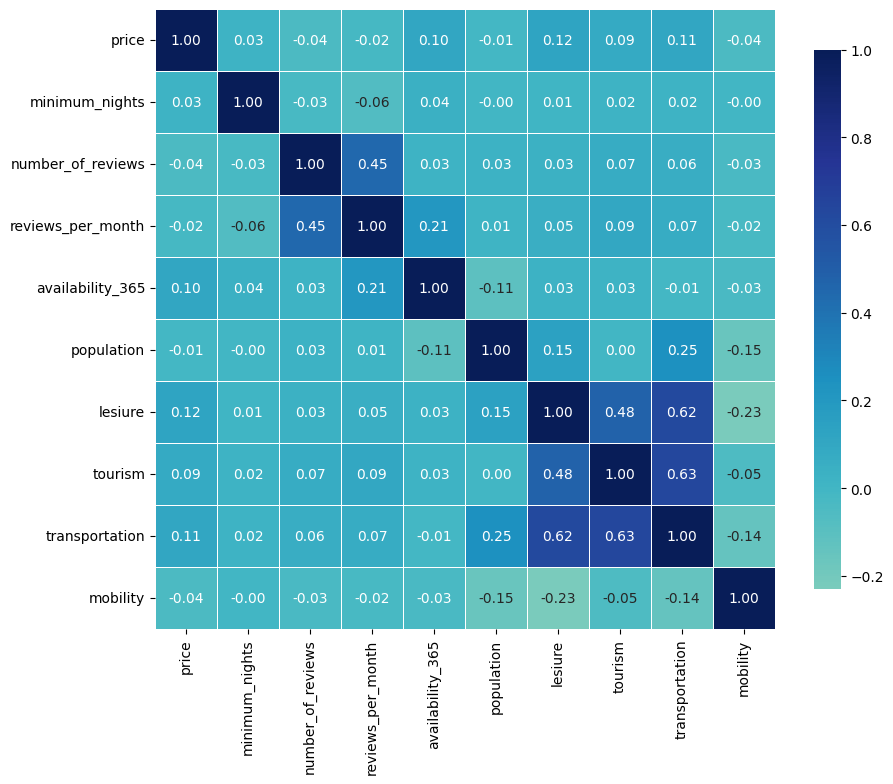

In [28]:
# Check correlation between input variables
# 入力変数間の相関をチェックする
correlations = gdf_clean.corr(numeric_only=True)

fig, axes = plt.subplots(figsize=(10,10), facecolor='white')
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=axes)
plt.show()

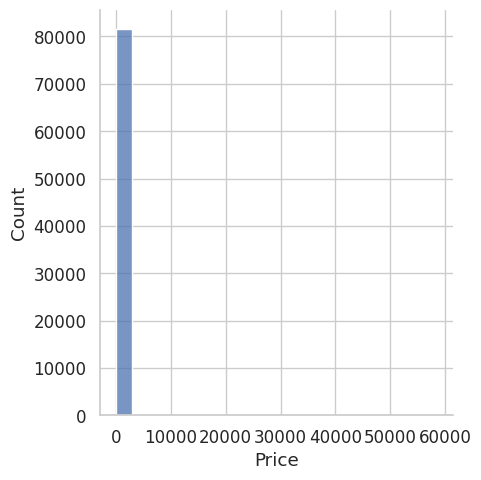

In [29]:
# Count plot for target variable
# ターゲット変数のカウントプロット
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})
sns.displot(gdf_clean['price'], kde=False, bins=20,).set(xlabel='Price', ylabel='Count');

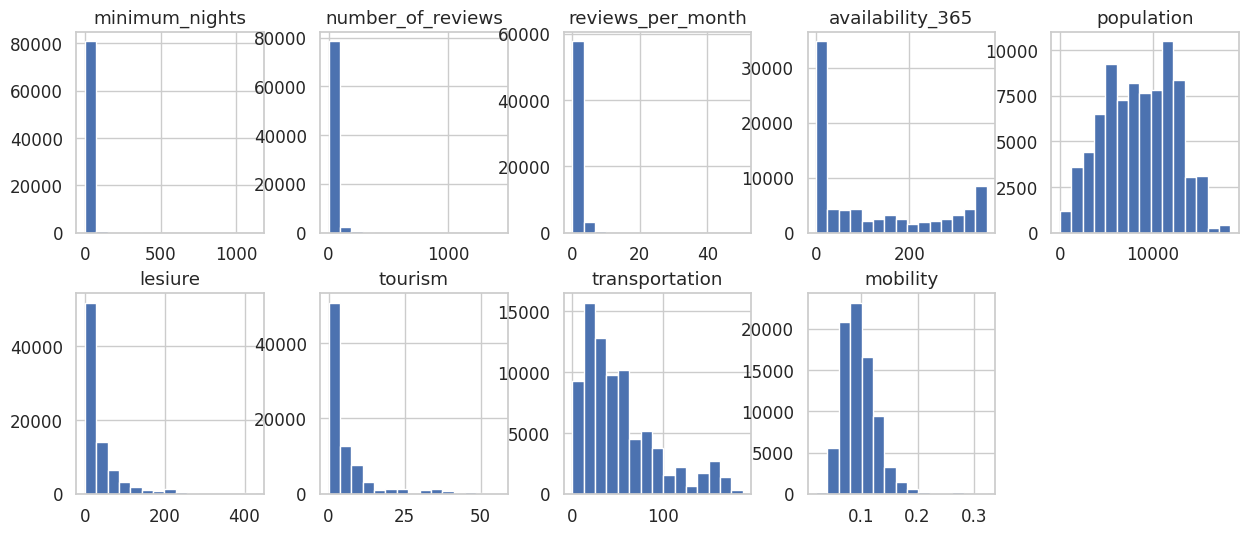

In [30]:
# Count plot for target numerical variables
# 数値変数のカウントプロット
gdf_clean[numerical_variables].hist(bins=15, figsize=(15, 6), layout=(2, 5));

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


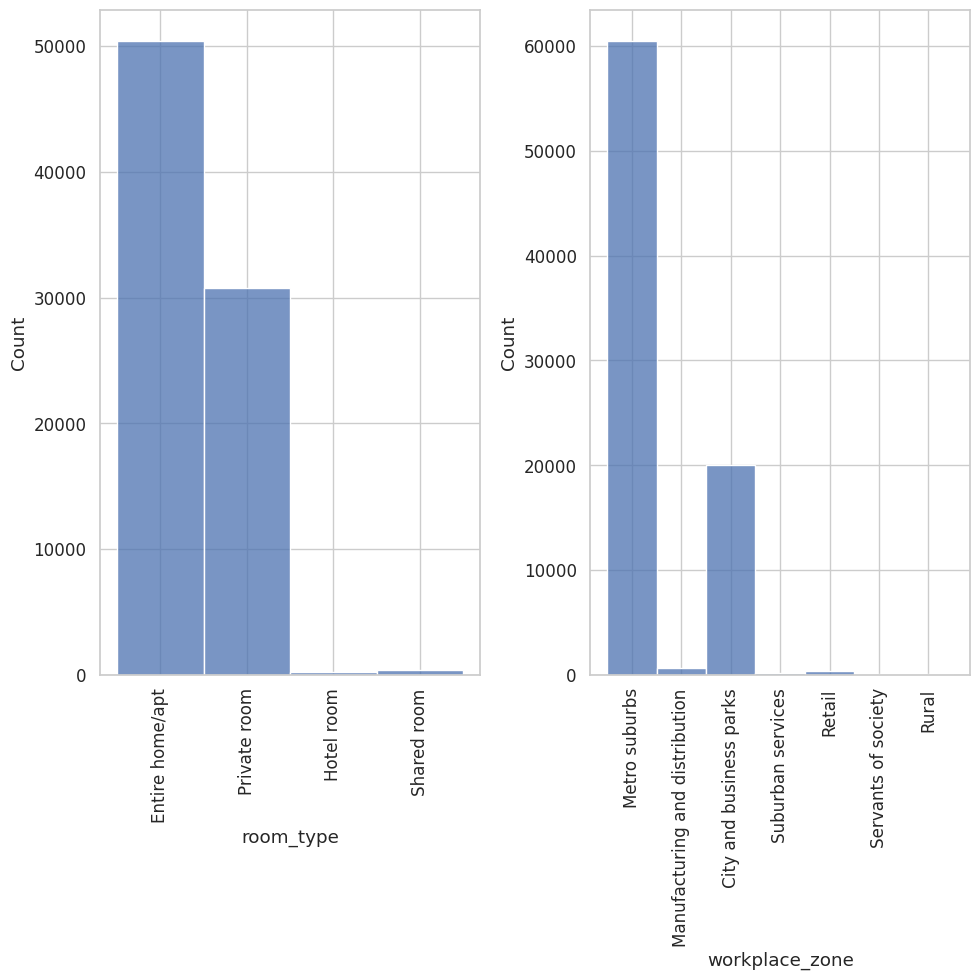

In [31]:
# Count plot for target categorical variables
# カテゴリー変数のカウントプロット

# Select the columns to be plotted
# プロットする列を選択する
cols = ["room_type", "workplace_zone"]

fig, axes = plt.subplots(1, 2)
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(gdf_clean[col], ax=ax).set_xticklabels(
        ax.get_xticklabels(), rotation=90
    )

fig.tight_layout()
plt.show()

## Null values and Outliers

In [32]:
# Use df.describe to check percentiles for each numerical colummn
# df.describeを使って各数値列のパーセンタイルをチェックする
gdf_selected = gdf_clean.copy()
gdf_selected.describe(percentiles=[.25, .5, .75, .95, .99])

,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility
count,81755.000000,81755.000000,81755.000000,61166.000000,81755.000000,81755.000000,81755.000000,81755.000000,81755.000000,81755.000000
mean,187.545508,5.648450,17.942695,0.970436,119.304948,8519.053966,36.522904,5.366767,52.397505,0.097697
std,477.538813,22.999768,42.247332,1.330555,133.869156,3745.084105,51.778037,8.736367,41.005148,0.030673
min,0.000000,1.000000,0.000000,0.010000,0.000000,10.962097,0.000000,0.000000,0.000000,0.021189
25%,61.000000,1.000000,0.000000,0.140000,0.000000,5634.368035,5.000000,0.000000,21.000000,0.076423
50%,110.000000,2.000000,4.000000,0.500000,59.000000,8637.996885,18.000000,2.000000,42.000000,0.092812
75%,198.000000,4.000000,16.000000,1.230000,245.000000,11479.420325,47.000000,6.000000,71.000000,0.113142
95%,514.300000,14.000000,82.000000,3.610000,361.000000,14366.825070,149.000000,26.000000,150.000000,0.148096
99%,1570.000000,90.000000,209.000000,6.100000,365.000000,15413.859685,233.000000,39.000000,165.000000,0.192593
max,58564.000000,1125.000000,1425.000000,50.500000,365.000000,18360.206098,427.000000,56.000000,187.000000,0.321531


In [33]:
# Remove data from selected columns not within the 99th percentile
# 選択された列から99パーセンタイル以内のデータを削除する。
gdf_selected = gdf_selected[gdf_selected['price'] >= 10]
gdf_selected = gdf_selected[gdf_selected['price'] <= 1570]
gdf_selected = gdf_selected[gdf_selected['minimum_nights'] <= 90]
gdf_selected

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,workplace_zone,mobility
index,,,,,,,,,,,,,
0,Lewisham,Entire home/apt,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
1,Lewisham,Entire home/apt,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
2,Lewisham,Private room,58.0,1.0,0.0,NaN,306.0,6840.458714,55.0,5.0,66.0,Metro suburbs,0.085938
3,Lewisham,Private room,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,Metro suburbs,0.085938
4,Lewisham,Entire home/apt,298.0,3.0,18.0,2.77,256.0,4883.326601,0.0,0.0,21.0,Metro suburbs,0.085938
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,Redbridge,Entire home/apt,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,Metro suburbs,0.061674
81751,Bromley,Private room,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,Metro suburbs,0.123348
81752,Bromley,Private room,200.0,1.0,0.0,NaN,365.0,4619.299667,5.0,0.0,12.0,Metro suburbs,0.123348


In [34]:
# Display null values
# ヌル値を表示する
display(gdf_selected.isnull().sum())

neighbourhood            0
room_type                0
price                    0
minimum_nights           0
number_of_reviews        0
reviews_per_month    20147
availability_365         0
population               0
lesiure                  0
tourism                  0
transportation           0
workplace_zone           0
mobility                 0
dtype: int64

In [35]:
# Fill remaining null values with 0
# 残りのヌル値を0で埋める
gdf_selected = gdf_selected.fillna(0)
display(gdf_selected.isnull().sum())

neighbourhood        0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
reviews_per_month    0
availability_365     0
population           0
lesiure              0
tourism              0
transportation       0
workplace_zone       0
mobility             0
dtype: int64

## Encoding

In [36]:
gdf_encoded = gdf_selected.copy()

In [37]:
# Display categorical features and their respective cardinality
# カテゴリカルな特徴とそれぞれのカーディナリティを表示します
display(gdf_encoded[categorical_variables])
for cat in categorical_variables:
    print(cat, gdf_encoded[cat].nunique())

,neighbourhood,room_type,workplace_zone
index,,,
0,Lewisham,Entire home/apt,Metro suburbs
1,Lewisham,Entire home/apt,Metro suburbs
2,Lewisham,Private room,Metro suburbs
3,Lewisham,Private room,Metro suburbs
4,Lewisham,Entire home/apt,Metro suburbs
...,...,...,...
81750,Redbridge,Entire home/apt,Metro suburbs
81751,Bromley,Private room,Metro suburbs
81752,Bromley,Private room,Metro suburbs


neighbourhood 33
room_type 4
workplace_zone 7


In [38]:
# Nominal variable and cardinality < 15, use OneHot Encoding
# 名目変数でカーディナリティが15未満の場合、OneHotエンコーディングを使用する。
gdf_encoded = pd.get_dummies(gdf_encoded, columns=["room_type", "workplace_zone"])

# Nominal variable and cardinality > 15, use Target Encoding
# 名目変数でカーディナリティが15を超える場合は、ターゲットエンコーディングを使用する。
encoder = ce.TargetEncoder()
gdf_encoded["neighbourhood"] = encoder.fit_transform(gdf_encoded['neighbourhood'], gdf_encoded['price'])
gdf_encoded

,neighbourhood,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
0,99.253586,44.0,6.0,1.0,0.01,0.0,6840.458714,55.0,5.0,66.0,...,0,0,0,0,0,1,0,0,0,0
1,99.253586,95.0,3.0,2.0,0.97,160.0,6840.458714,55.0,5.0,66.0,...,0,0,0,0,0,1,0,0,0,0
2,99.253586,58.0,1.0,0.0,0.00,306.0,6840.458714,55.0,5.0,66.0,...,0,1,0,0,0,1,0,0,0,0
3,99.253586,36.0,7.0,3.0,0.49,170.0,8076.051548,5.0,1.0,13.0,...,0,1,0,0,0,1,0,0,0,0
4,99.253586,298.0,3.0,18.0,2.77,256.0,4883.326601,0.0,0.0,21.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81750,107.355499,400.0,5.0,3.0,0.05,0.0,1469.876338,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
81751,105.273115,57.0,1.0,70.0,5.90,236.0,3089.929155,20.0,0.0,17.0,...,0,1,0,0,0,1,0,0,0,0
81752,105.273115,200.0,1.0,0.0,0.00,365.0,4619.299667,5.0,0.0,12.0,...,0,1,0,0,0,1,0,0,0,0


In [39]:
# Check dtypes of final cleaned,selected and encoded table
# 最終的にクリーニングされ、選択され、エンコードされたテーブルのd型をチェックする
gdf_encoded.dtypes

neighbourhood                                    float64
price                                            float64
minimum_nights                                   float64
number_of_reviews                                float64
reviews_per_month                                float64
availability_365                                 float64
population                                       float64
lesiure                                          float64
tourism                                          float64
transportation                                   float64
mobility                                         float64
room_type_Entire home/apt                          uint8
room_type_Hotel room                               uint8
room_type_Private room                             uint8
room_type_Shared room                              uint8
workplace_zone_City and business parks             uint8
workplace_zone_Manufacturing and distribution      uint8
workplace_zone_Metro suburbs   

In [40]:
# Split dataset into dependent and independent variables (X and y)
# データセットを従属変数と独立変数 (X と y) に分割する
X = gdf_encoded.drop("price", axis=1).copy()
y = gdf_encoded["price"].copy()

# Split X and y data into train and test data 80/20
# XとYのデータを訓練データとテストデータに分ける 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14, test_size=.2)

In [41]:
# Visualize final split data
# 最終的な分割データを視覚化する
display(X_train)
display(y_train)
display(X_test)
display(y_test)

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
52986,99.949474,5.0,16.0,0.26,344.0,4748.283632,0.0,0.0,9.0,0.088483,...,0,1,0,0,0,1,0,0,0,0
69538,145.586670,1.0,1.0,0.02,350.0,11418.189404,59.0,15.0,93.0,0.092322,...,1,0,0,1,0,0,0,0,0,0
30060,156.746736,1.0,0.0,0.00,0.0,6646.833291,7.0,7.0,33.0,0.093213,...,0,1,0,0,0,1,0,0,0,0
11646,278.001920,1.0,5.0,3.13,34.0,11656.632046,233.0,9.0,75.0,0.068103,...,0,1,0,0,0,1,0,0,0,0
47835,142.525349,3.0,0.0,0.00,0.0,5469.188948,0.0,0.0,16.0,0.094309,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79470,145.586670,2.0,177.0,1.93,24.0,11996.222109,9.0,1.0,32.0,0.081633,...,0,0,0,0,0,1,0,0,0,0
45309,119.449510,4.0,0.0,0.00,364.0,12679.400477,3.0,0.0,33.0,0.117647,...,0,0,0,0,0,1,0,0,0,0
23153,120.356747,1.0,16.0,0.28,0.0,9199.765938,7.0,2.0,37.0,0.077358,...,0,1,0,0,0,1,0,0,0,0


index
52986     43.0
69538    170.0
30060     22.0
11646    200.0
47835     31.0
         ...  
79470    244.0
45309    350.0
23153     26.0
9578      95.0
80100     60.0
Name: price, Length: 64664, dtype: float64

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,availability_365,population,lesiure,tourism,transportation,mobility,...,room_type_Hotel room,room_type_Private room,room_type_Shared room,workplace_zone_City and business parks,workplace_zone_Manufacturing and distribution,workplace_zone_Metro suburbs,workplace_zone_Retail,workplace_zone_Rural,workplace_zone_Servants of society,workplace_zone_Suburban services
index,,,,,,,,,,,,,,,,,,,,,
75299,99.949474,1.0,0.0,0.00,83.0,6605.006879,6.0,0.0,12.0,0.062847,...,0,1,0,0,0,1,0,0,0,0
20927,174.330347,3.0,40.0,3.16,8.0,11796.806246,3.0,3.0,37.0,0.049367,...,0,0,0,1,0,0,0,0,0,0
17875,126.160883,3.0,3.0,0.04,0.0,12949.064945,26.0,1.0,35.0,0.161049,...,0,0,0,0,0,1,0,0,0,0
12316,174.330347,1.0,1.0,0.02,0.0,15092.350274,23.0,4.0,32.0,0.090465,...,0,0,0,0,0,1,0,0,0,0
60888,278.001920,3.0,4.0,1.02,15.0,11656.632046,233.0,9.0,75.0,0.052521,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77177,174.330347,2.0,0.0,0.00,110.0,8900.329495,48.0,1.0,50.0,0.144593,...,0,0,0,0,0,1,0,0,0,0
59146,119.449510,2.0,0.0,0.00,0.0,12325.421078,4.0,2.0,25.0,0.120000,...,0,0,0,0,0,1,0,0,0,0
32160,174.330347,3.0,18.0,0.32,270.0,15092.350274,23.0,4.0,32.0,0.094395,...,0,0,0,0,0,1,0,0,0,0


index
75299    125.0
20927    110.0
17875     65.0
12316    100.0
60888    192.0
         ...  
77177    195.0
59146     40.0
32160    150.0
41374    495.0
30908     90.0
Name: price, Length: 16167, dtype: float64

# Models

## XGBOOST

In [44]:
# Create model instance
# モデルのインスタンスを作成する
xgb_model = xgb.XGBRegressor(
    seed=39,
    eval_metric=["mae", "rmse"],
    #gpu_id=0,
    #tree_method = 'gpu_hist',
    #predictor = 'gpu_predictor'
)

In [45]:
# Train the model
# モデルをトレーニングする
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, verbose=0, eval_set=eval_set)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [46]:
# Make predictions on our test data
# テストデータで予測を行う
preds = xgb_model.predict(X_test)
predictions = [round(value) for value in preds]
print(predictions[0:10])
print([round(value) for value in list(y_test)][0:10])

[68, 201, 93, 113, 239, 142, 54, 60, 128, 252]
[125, 110, 65, 100, 192, 95, 45, 38, 150, 209]


In [47]:
# Evaluate model
# モデルを評価する

# R2 score / R2スコア
print("R^2 :", r2_score(y_test, predictions))
# Adjusted R2 / 調整後R2
print("Adjusted R^2 :", 1 - (1-xgb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))
# Mean Average Error / 平均平均誤差
print("MAE :", mean_absolute_error(y_test,predictions))
# Root Mean Squared Error / 平均二乗誤差
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

R^2 : 0.5531230712426827
Adjusted R^2 : 0.6583243196868767
MAE : 71.72598503123648
RMSE: 133.26566183374896


## Validation & Plotting

In [48]:
# Calculate the shap values (GPU reccomended)
# シャップ値を計算する（GPU推奨）
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 167.58547973632812


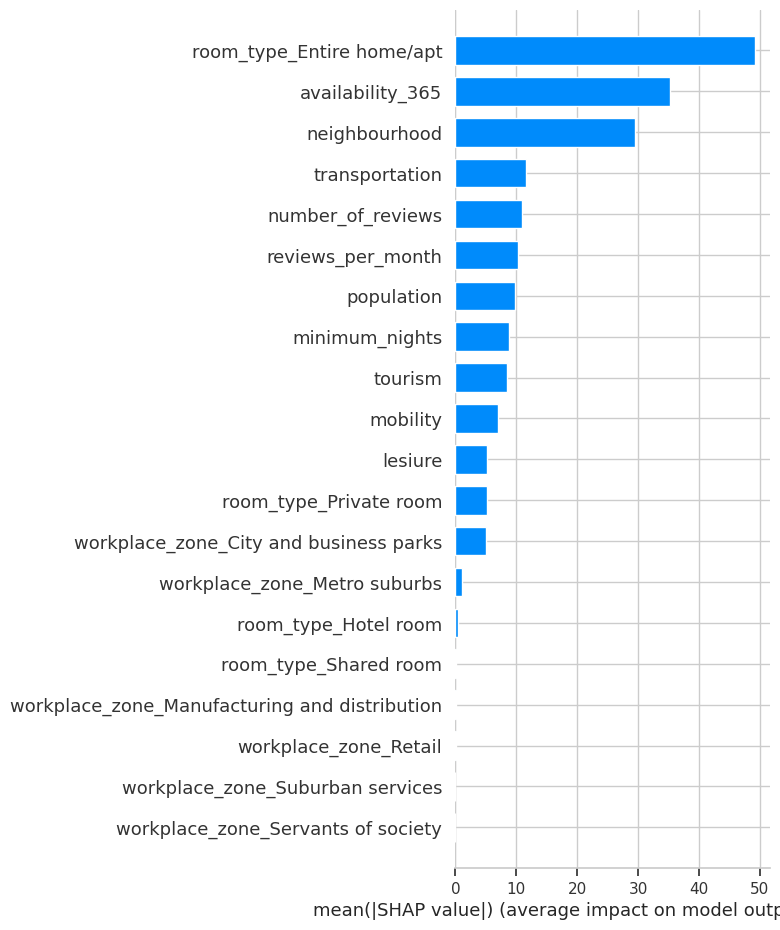

In [49]:
# Create summary plot, showing the most impactful features
# 最もインパクトのある特徴を示すサマリープロットを作成する
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


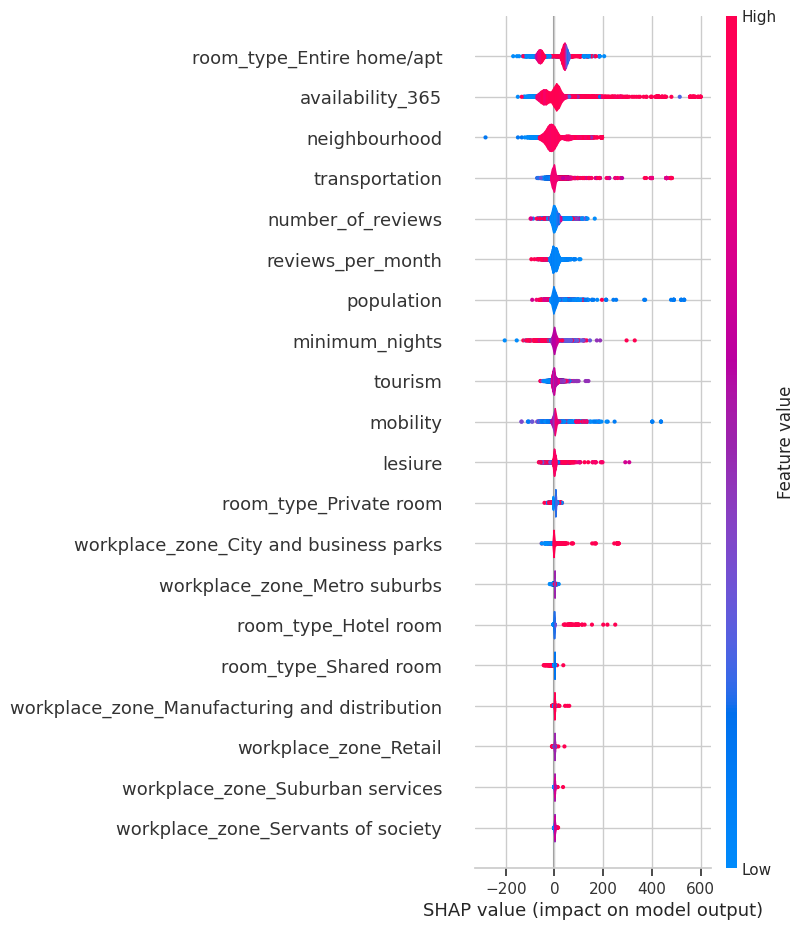

In [50]:
# Same plot as above but this time we can see the distribution of values
# 上と同じプロットだが、今回は値の分布を見ることができる
shap.summary_plot(shap_values, X_test, plot_type='violin', show=True)

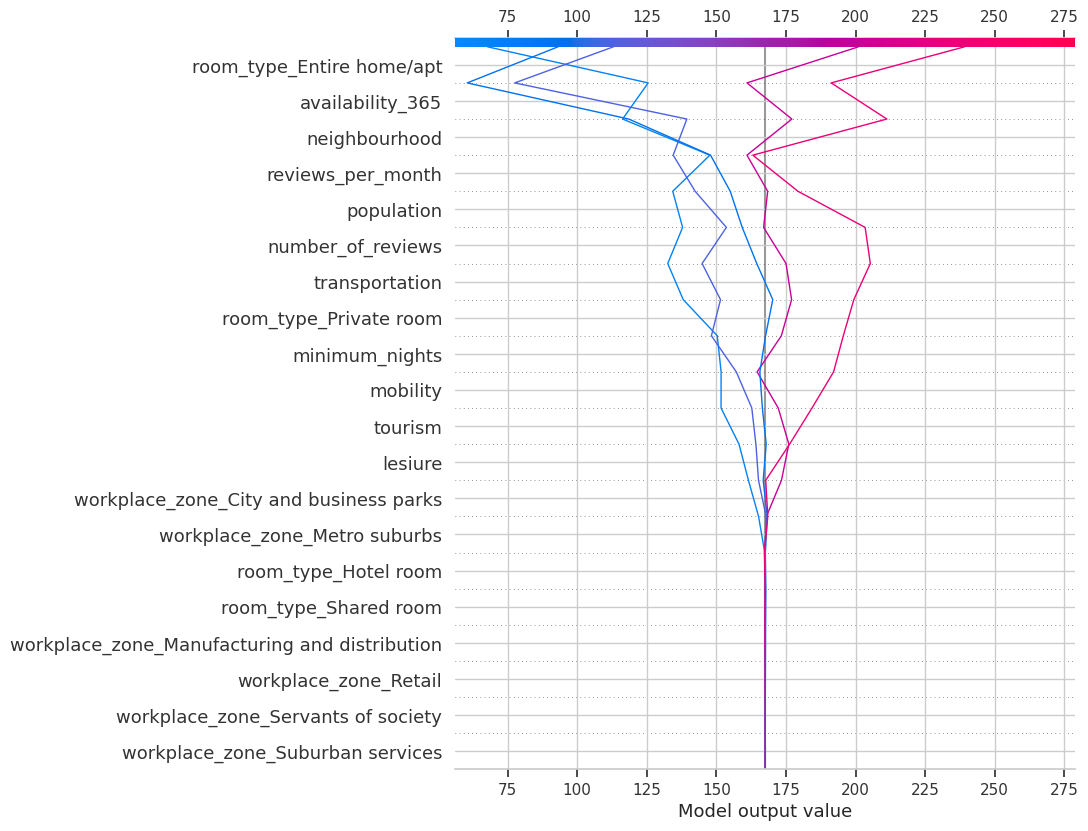

In [51]:
# Create a decision plot for the first 5 predictions, showing how the model arrived at its prediction
# 最初の5つの予測についてデシジョンプロットを作成し、モデルがどのように予測に至ったかを示す
select = range(5)
features = X_test.iloc[select]
shap_values = explainer.shap_values(features)

shap.decision_plot(expected_value, shap_values, features, show=True)

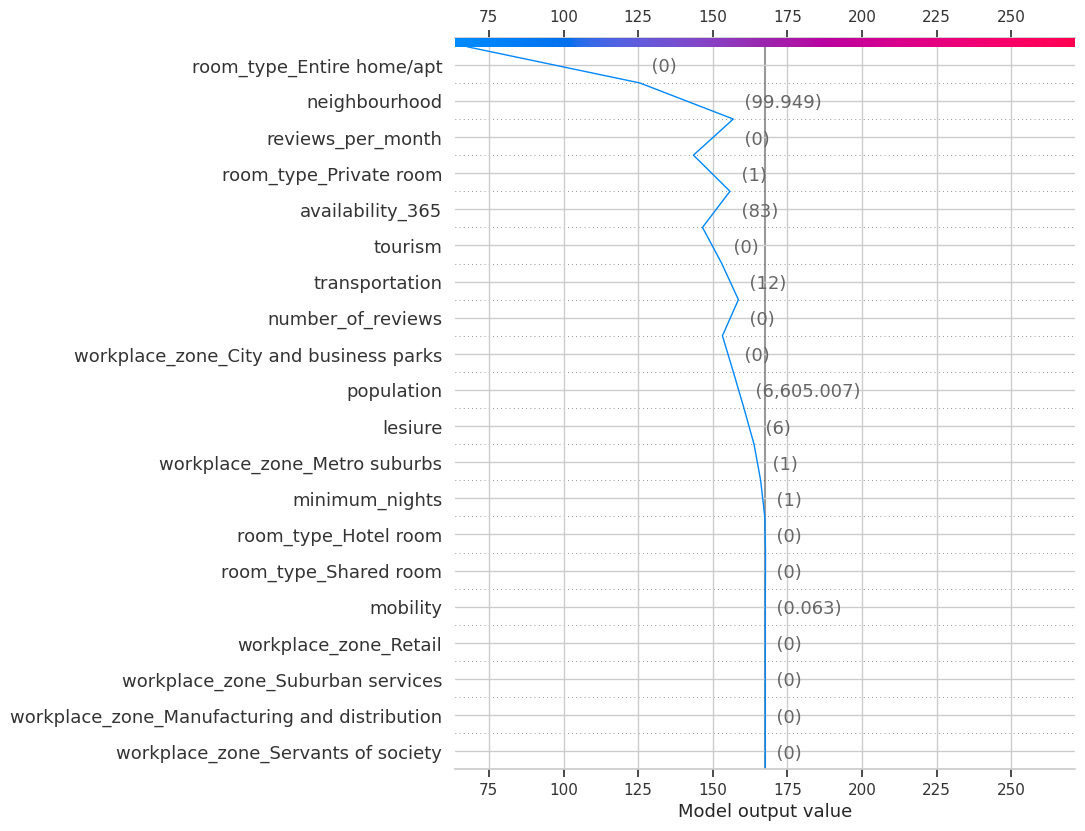

In [52]:
# Same plot as above but with one prediction only so we can see the values at each step
# 各ステップでの値を見ることができるように、上記と同じプロットだが、予測は1回のみとする
select = range(1)
features = X_test.iloc[select]

shap_values = explainer.shap_values(features)
shap.decision_plot(expected_value, shap_values, features, show=True)

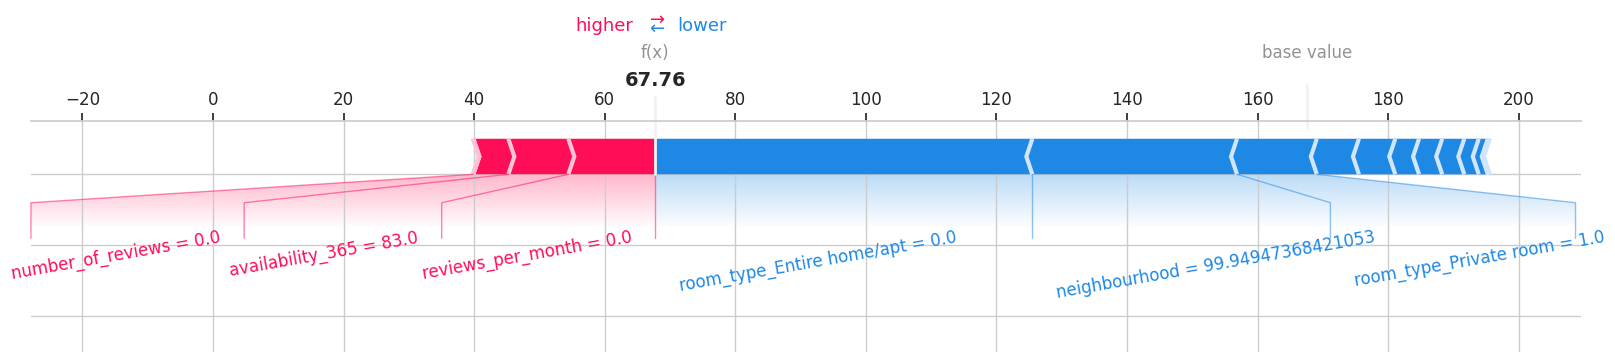

In [53]:
# Create force plot for the same predictions, a different way of visualizing feature impact
# 同じ予測に対してフォースプロットを作成し、特徴の影響を別の方法で視覚化する
select = range(1)
features = X_test.iloc[select]
shap_values = explainer.shap_values(features)

shap.force_plot(expected_value, shap_values, features, text_rotation=10, matplotlib=True)

## Model optimization


In [ ]:
# Initialize default model and choose the combination of hyperparameters to use during GridSearch
# デフォルトモデルを初期化し、グリッドサーチ時に使用するハイパーパラメータの組み合わせを選択する
reg_model = xgb.XGBRegressor(gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor')
grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [8, 10, 12],
    "min_child_weight": [1, 3],
    "gamma":[0.0, 0.1],
    "colsample_bytree":[0.5, 1]
}

# Run the GridSearch (around 2 minutes, GPU session reccomended)
# グリッドサーチの実行（2分程度、GPUセッション推奨）
grid_search = GridSearchCV(
            estimator=reg_model,
            param_grid=grid,
            cv=2,
            scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters found by GridSearch
# GridSearchによって見つかった最適なパラメータを表示する
print(f"Best parameters: {grid_search.best_params_}")

In [ ]:
# Print a few of the many runs made by during the GridSearch
# GridSearch中に実行された多くのランのうちのいくつかを表示する
pd.DataFrame(grid_search.cv_results_).head()

In [ ]:
# Create optimzed model instance
# 最適化されたモデルインスタンスを作成する
xgb_model_opt = xgb.XGBRegressor(
    **grid_search.best_params_, # Best parameters / 最高のパラメーター
    n_estimators = 200, # More complex model so use twice the estimators / より複雑なモデルのため、2倍の推定量を使用
    seed=39,
    eval_metric=["mae", "rmse"],
    gpu_id=0,
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor'
)

# Train the model
# モデルをトレーニングする
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model_opt.fit(X_train, y_train, verbose=0, eval_set=eval_set)

# Make predictions on our test data
# テストデータで予測を行う
preds_opt = xgb_model_opt.predict(X_test)
predictions_opt = [round(value) for value in preds_opt]

# R2 score / R2スコア
print("R^2 :", r2_score(y_test, predictions))
# Adjusted R2 / 調整後R2
print("Adjusted R^2 :", 1 - (1-xgb_model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))
# Mean Average Error / 平均平均誤差
print("MAE :", mean_absolute_error(y_test,predictions))
# Root Mean Squared Error / 平均二乗誤差
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

# Prediction

In [ ]:
# Make predictions and joined them back to test data
# 予測を立て、それをテストデータに結びつける
gdf_out = X_test.copy()
gdf_out["price_predicted"] = xgb_model_opt.predict(X_test)
gdf_out = gdf_out.merge(gdf_load, left_on="index", right_on="index")[
    ["h3", "price", "price_predicted"]
]
gdf_out.reset_index(drop=True, inplace=True)
gdf_out

In [ ]:
# Export DataFrame to local file (.parquet)
# データフレームをローカルファイル（.parquet）にエクスポートする。
# gdf_out.to_parquet('london_listings_2023_predicted.parquet')

In [ ]:
# Upload result to our Carto account and overwrite same table if already present
# 結果をCartoアカウントにアップロードし、同じテーブルが存在する場合は上書きする
job_config = bigquery.LoadJobConfig(schema=[], write_disposition="WRITE_TRUNCATE")
carto_dw_client.load_table_from_dataframe(
    gdf_out,
    f"{cdw_dataset}.shared_us.london_listings_2023_predicted",
    job_config=job_config,
).result()

In [ ]:
# List tables again and see if out new table is there
# テーブルを再度リストアップし、新しいテーブルがあるかどうかを確認する
dataset_id = 'shared_us'
tables = carto_dw_client.list_tables(dataset_id)

print("Tables contained in '{}':".format(dataset_id))
for table in tables:
    print("{}.{}.{}".format(table.project, table.dataset_id, table.table_id))

In [ ]:
# Create final map to visualize our predictions
# 予測を視覚化する最終マップを作成する
pdkc.register_carto_layer()

layer = pdk.Layer(
    "CartoLayer",
    data=f"SELECT h3, price_predicted, price FROM `{cdw_dataset}.shared_us.london_listings_2023_predicted`",
    type_=pdkc.MapType.QUERY,
    connection=pdkc.CartoConnection.CARTO_DW,
    credentials=pdkc.get_layer_credentials(carto_auth),

    aggregation_exp=pdk.types.String("avg(price_predicted) as price_predicted"),
    aggregation_res_level=8,
    geo_column=pdk.types.String("h3"),

    #get_fill_color='[255, 255, properties.growth * 255]'
    get_fill_color=pdkc.styles.color_bins("price_predicted",[0, 100, 200, 300, 400, 500], "Sunset"),
    opacity=0.5,

    get_elevation='properties.price_predicted * properties.price_predicted',
    elevation_scale=0.01,

    get_elevation='properties.price_predicted',
    elevation_scale=10,

    # get_line_color=[0, 0, 0, 100],
    # line_width_min_pixels=1,

    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    auto_highlight=True,
    pickable=True
)

tooltip = {"html": "<b>H3 Index:</b> {id} <br /><b>Predicted Price:</b> {price_predicted}"}

view_state = pdk.ViewState(
    latitude=51.50071697877869,
    longitude=-0.12461158468895285,
    zoom=8,
    pitch=45,
    bearing=0
  )

pdk.Deck(layer, map_style=pdk.map_styles.DARK, tooltip=tooltip, initial_view_state=view_state).to_html(iframe_height=800)